## Data and Package Importing

In [1]:
import sklearn.preprocessing as sp
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80)

In [ ]:
# reload fcc module while working
import sys
del sys.modules['QC']
from QC import *

### Mouse Data

In [2]:
train = sc.read_h5ad('../data/2771-AS-1-GCCAAT_S1.h5ad')
test = sc.read_h5ad('../data/3777-SM-1-GCCAAT_S1.h5ad')
#3777-SM-2-CTTGTA_S2.h5ad
#3777-SM-1-GCCAAT_S1.h5ad
test.raw = test

In [3]:
%%time
# create new "observations" as percent and mean mito genes
train.var['mito'] = train.var_names.str.contains('mt-') # identify mitochondrial genes
train.obs['mean_mito'] = np.mean(train[:,train.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(train, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# create new "observations" as percent and mean mito genes
test.var['mito'] = test.var_names.str.contains('mt-') # identify mitochondrial genes
test.obs['mean_mito'] = np.mean(test[:,test.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(test, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# rank cells by total counts and save as .obs
train.obs['ranked_total_counts'] = np.argsort(train.obs['total_counts'])
test.obs['ranked_total_counts'] = np.argsort(test.obs['total_counts'])

Wall time: 11.9 s


In [4]:
train.obs['set'] = 'train'
test.obs['set'] = 'test'

In [5]:
merge_data = train.concatenate(test) #Merge Train and Test

### Normalize and dimensionality reduction with PCA

In [6]:
%%time
sc.pp.normalize_total(merge_data, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(merge_data) # log1p transformation
sc.pp.scale(merge_data, max_value=10) # scaling by variance and centering to zero for visualization

Wall time: 34.9 s


In [ ]:
sc.pp.normalize_total(test, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(test) # log1p transformation
sc.pp.scale(test, max_value=10) # scaling by variance and centering to zero for visualization

In [ ]:
sc.tl.pca(test, n_comps=100)

In [ ]:
sc.tl.tsne(test, n_pcs=100,n_jobs=-1) # perform tsne and plot results

... storing 'set' as categorical


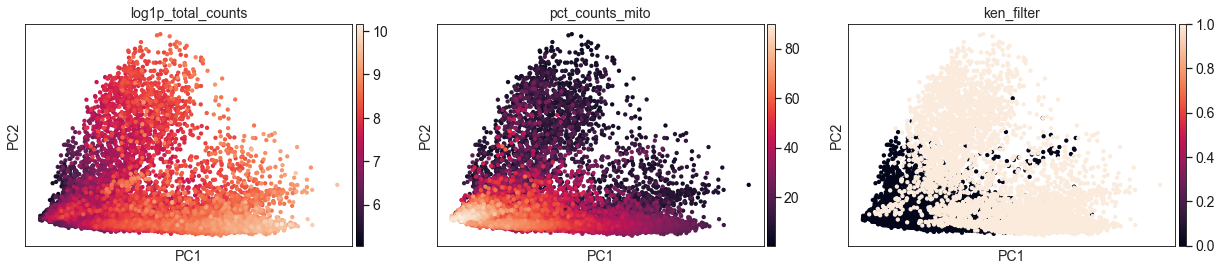

In [7]:
sc.tl.pca(merge_data, n_comps=100) # perform PCA and plot results
sc.pl.pca(merge_data, color=['log1p_total_counts','pct_counts_mito','ken_filter'], ncols=4, size=75)

#### Cross Group Binary 

In [8]:
#Prepare train and test
array1 = np.where(merge_data.obs['set']== 'train')
array2 = np.where(merge_data.obs['set']== 'test')
X=merge_data.obsm['X_pca'] 
y=merge_data.obs['ken_filter']

In [9]:
%%time
lr = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial', max_iter=1000)
rf = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=2)
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
gb = GradientBoostingClassifier(n_estimators=100, random_state=0)
#select desired classifier
lr.fit(X[array1[0]], y[array1[0]]) #training
prediction =lr.predict(X[array2[0]]) #testing

Wall time: 46.2 s


In [10]:
test.obs['binary']=prediction

In [11]:
#Accuracy measure
f_positive = 0
f_negative = 0
for i in range(0,len(test)):
    if test.obs['binary'][i]-test.obs['ken_filter'][i]>0:
        f_positive +=1
    if test.obs['binary'][i]-test.obs['ken_filter'][i]<0:
        f_negative +=1
total_acc = 1-((f_positive+f_negative)/len(test))
print('miss-labeled as cell:',f_positive,'; mislabeled as empty:',f_negative,'; Total Accuracy is %0.2f)' % total_acc)

miss-labeled as cell: 437 ; mislabeled as empty: 216 ; Total Accuracy is 0.94)


In [12]:
test.obs['ken_filter'].value_counts()

0    7576
1    2990
Name: ken_filter, dtype: int64

In [ ]:
sc.pl.tsne(test, color=['log1p_total_counts','pct_counts_mito','binary','ken_filter'], ncols=4, size=75)

## Clustering

In [37]:
test_filter = test[test.obs['binary']==1,:].copy() # move forward with non-empty droplets
test_filter.X = test_filter.raw.X

In [38]:
%%time
test_filter.X = sp.normalize(test_filter.X, norm = 'l1') # each gene count value is divided by the total number of counts for that respective cell  
transformer = sp.FunctionTransformer(np.log1p,validate=True)
test_filter.X= transformer.transform(test_filter.X*100)
#sc.pp.scale(test_filter, max_value=1)

Wall time: 3.53 s


... storing 'set' as categorical


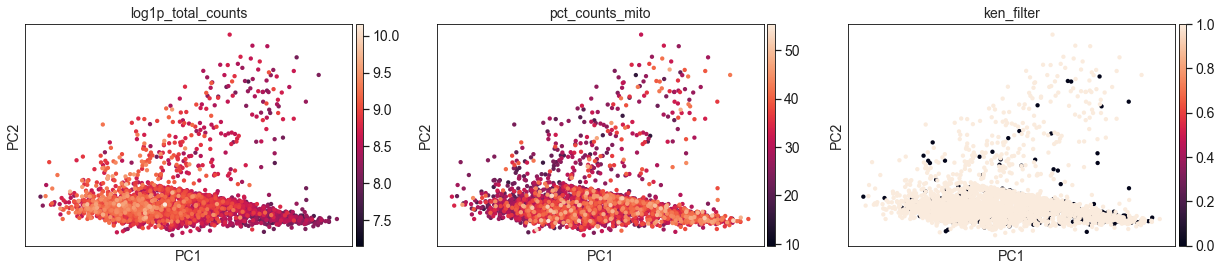

Wall time: 10.6 s


In [39]:
%%time
sc.tl.pca(test_filter, n_comps=100) # perform PCA and plot results
sc.pl.pca(test_filter, color=['log1p_total_counts','pct_counts_mito','ken_filter'], size=75)

In [40]:
%%time
sc.pp.neighbors(test_filter, n_neighbors=50, n_pcs=100, random_state=1)
sc.tl.louvain(test_filter, resolution=1.5, random_state=20) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters


Wall time: 2.88 s


In [41]:
sc.tl.tsne(test_filter,n_pcs= 100, n_jobs=-1,perplexity=20, random_state=100)

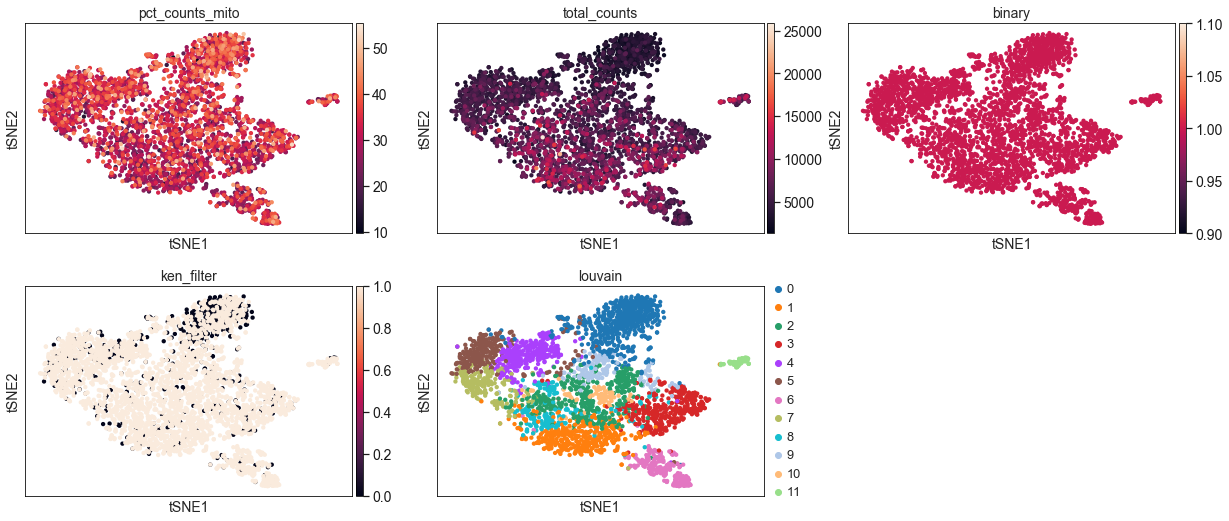

In [42]:

sc.pl.tsne(test_filter,color=['pct_counts_mito','total_counts','binary','ken_filter','louvain'], size=75, ncols=3 )

C:\Users\Lau Lab\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:381: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
C:\Users\Lau Lab\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:381: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
C:\Users\Lau Lab\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:388: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


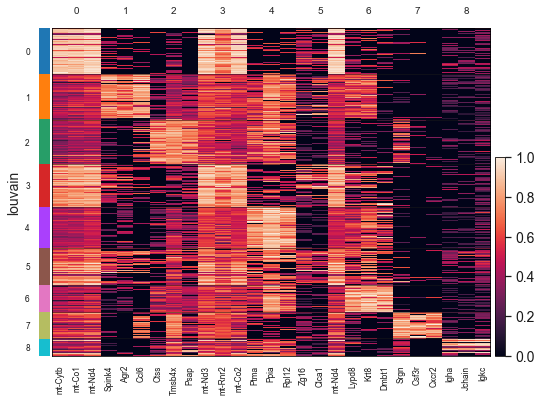

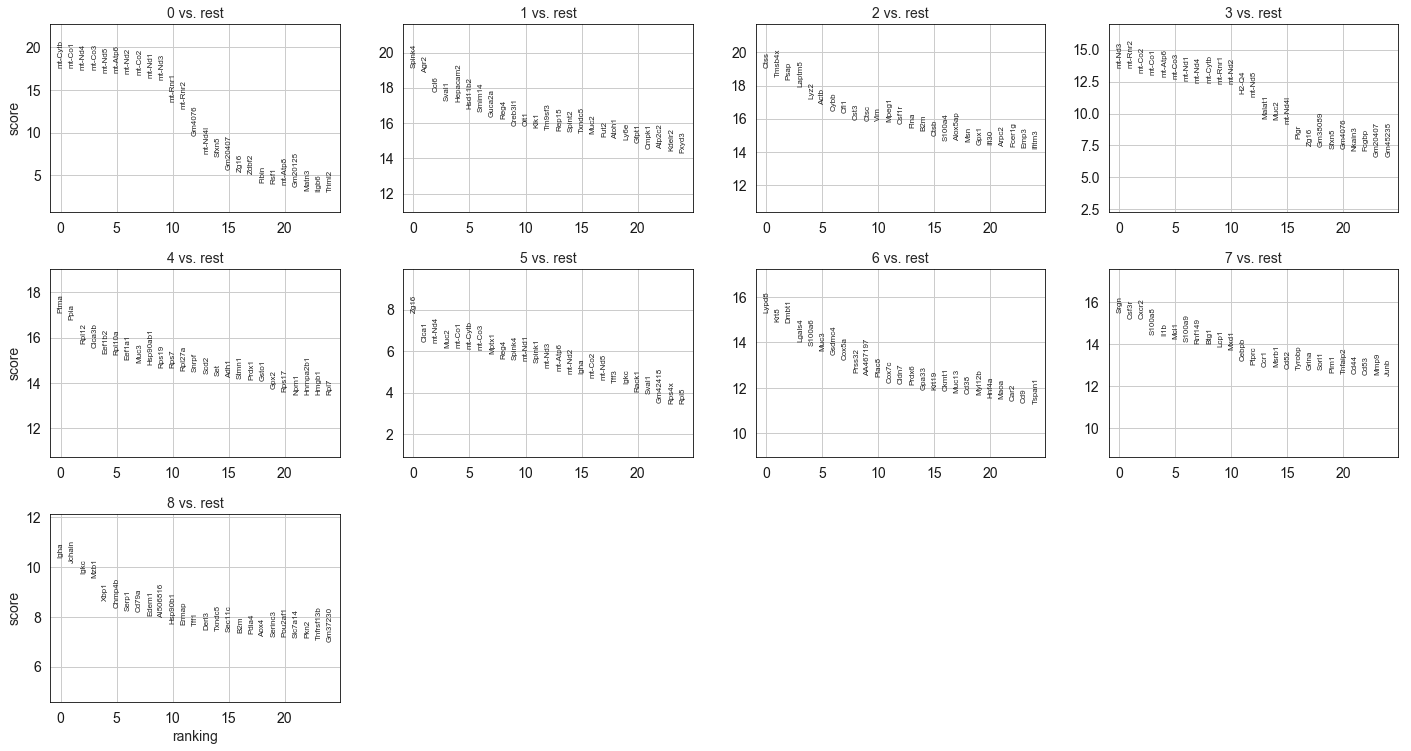

Wall time: 12.2 s


In [59]:
%%time
sc.tl.rank_genes_groups(test_filter, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(test_filter, n_genes=3, standard_scale='var', use_raw=False, dendrogram=False)
sc.pl.rank_genes_groups(test_filter, n_genes=25, sharey=False)

In [60]:
#Top 20 gene signatures
pd.DataFrame(test_filter.uns['rank_genes_groups']['names']).head(20)

,0,1,2,3,4,5,6,7,8
0,mt-Cytb,Spink4,Ctss,mt-Nd3,Ptma,Zg16,Lypd8,Srgn,Igha
1,mt-Co1,Agr2,Tmsb4x,mt-Rnr2,Ppia,Clca1,Krt8,Csf3r,Jchain
2,mt-Nd4,Ccl6,Psap,mt-Co2,Rpl12,mt-Nd4,Dmbt1,Cxcr2,Igkc
3,mt-Co3,Sval1,Laptm5,mt-Co1,Clca3b,Muc2,Lgals4,S100a8,Mzb1
4,mt-Nd5,Hepacam2,Lyz2,mt-Atp6,Eef1b2,mt-Co1,S100a6,Il1b,Xbp1
5,mt-Atp6,Hsd11b2,Actb,mt-Co3,Rpl10a,mt-Cytb,Muc3,Mcl1,Chmp4b
6,mt-Nd2,Smim14,Cybb,mt-Nd1,Eef1a1,mt-Co3,Gsdmc4,S100a9,Serp1
7,mt-Co2,Guca2a,Cfl1,mt-Nd4,Muc3,Mptx1,Cox5a,Rnf149,Cd79a
8,mt-Nd1,Reg4,Cst3,mt-Cytb,Hsp90ab1,Reg4,Prss32,Btg1,Edem1
9,mt-Nd3,Creb3l1,Ctsc,mt-Rnr1,Rps19,Spink4,AA467197,Lcp1,AI506816


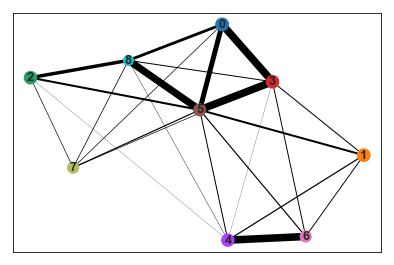

In [61]:
sc.tl.paga(test_filter, groups='louvain')
sc.pl.paga(test_filter)

---
## Ken Filtering

In [26]:
test_filter2 = test[test.obs['ken_filter']==1,:].copy() # move forward with non-empty droplets
test_filter2.X = test_filter2.raw.X

In [27]:
%%time
test_filter2.X = sp.normalize(test_filter2.X, norm = 'l1') # each gene count value is divided by the total number of counts for that respective cell  
transformer = sp.FunctionTransformer(np.log1p,validate=True)
test_filter2.X= transformer.transform(test_filter2.X*100)

Wall time: 594 ms


array([[0.        , 0.        , 0.00387162, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01345533, 0.03139577, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03633721, 0.01557309, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.05646528, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

... storing 'set' as categorical


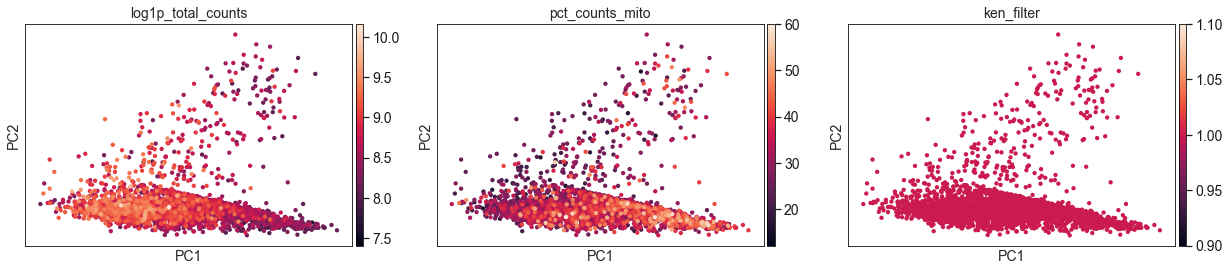

Wall time: 10 s


In [29]:
%%time
sc.tl.pca(test_filter2, n_comps=100) # perform PCA and plot results
sc.pl.pca(test_filter2, color=['log1p_total_counts','pct_counts_mito','ken_filter'], size=75)

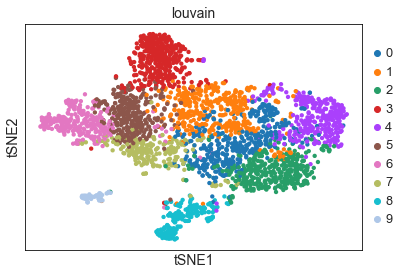

Wall time: 52.1 s


In [30]:
%%time
sc.pp.neighbors(test_filter2, n_neighbors=30, n_pcs=100, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(test_filter2, resolution=1, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters
sc.tl.tsne(test_filter2,n_pcs=100, n_jobs=-1, perplexity = 20,random_state=20)
sc.pl.tsne(test_filter2, color=['louvain'], size=75, ncols=3 )

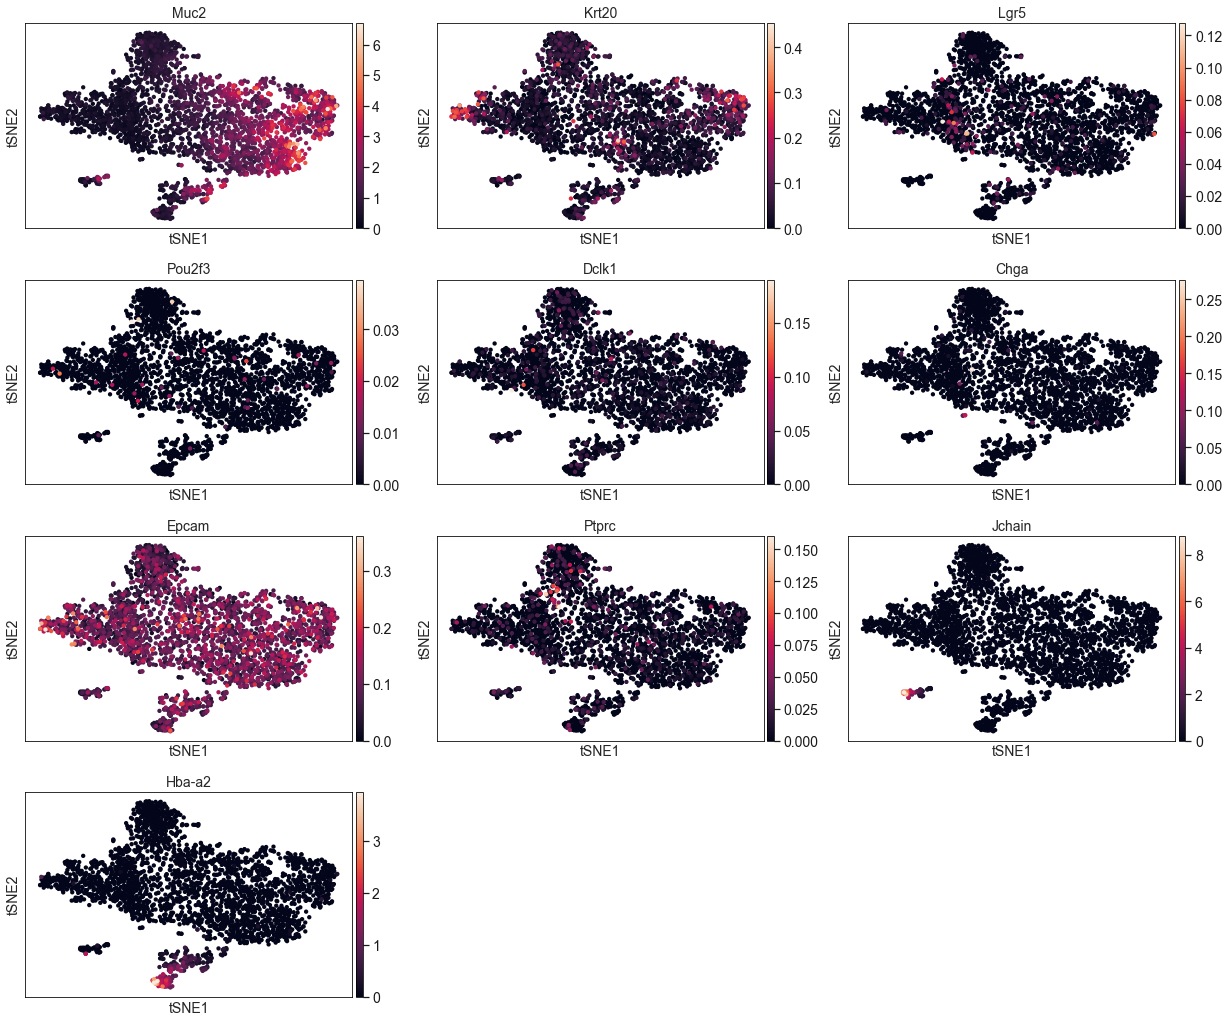

In [44]:
f = sc.pl.tsne(test_filter2, color = ['Muc2','Krt20','Lgr5','Pou2f3','Dclk1','Chga','Epcam','Ptprc','Jchain','Hba-a2'], size=75, ncols=3 )
               #save = 'Signature.png')

In [ ]:
sc.tl.umap(test_filter2)
sc.pl.umap(test_filter2, color=['pct_counts_mito','log1p_total_counts','binary','ken_filter','louvain'], size=75, ncols=3)

In [ ]:
sc.pl.umap(test_filter2, color = ['Muc2','Krt20','Lgr5','Pou2f3','Dclk1','Chga','Epcam','Ptprc','Jchain','Hba-a2'], size=75, ncols=3)

C:\Users\Lau Lab\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
C:\Users\Lau Lab\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:208: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
C:\Users\Lau Lab\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:223: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


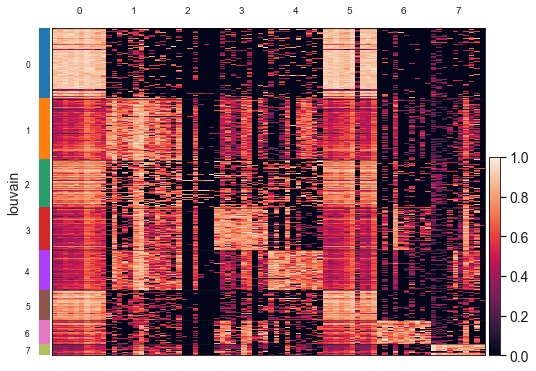

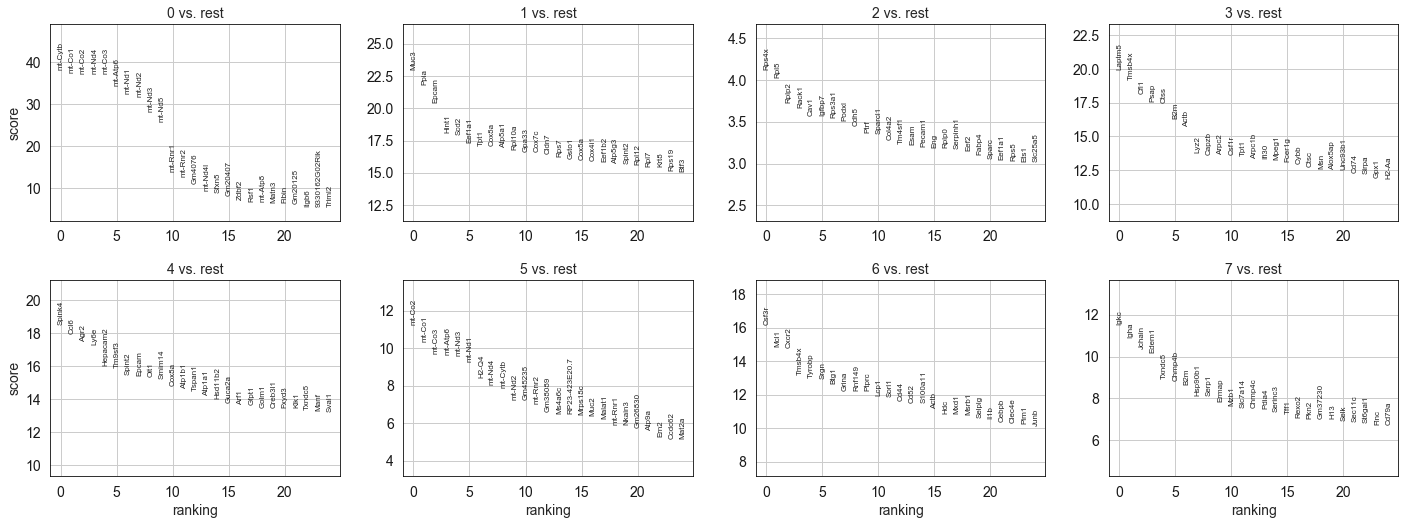

Wall time: 6.09 s


,0,1,2,3,4,5,6,7
0,mt-Cytb,Muc3,Rps4x,Laptm5,Spink4,mt-Co2,Csf3r,Igkc
1,mt-Co1,Ppia,Rpl5,Tmsb4x,Ccl6,mt-Co1,Mcl1,Igha
2,mt-Co2,Epcam,Rplp2,Cfl1,Agr2,mt-Co3,Cxcr2,Jchain
3,mt-Nd4,Hint1,Rack1,Psap,Ly6e,mt-Atp6,Tmsb4x,Edem1
4,mt-Co3,Scd2,Cav1,Ctss,Hepacam2,mt-Nd3,Tyrobp,Txndc5
5,mt-Atp6,Eef1a1,Igfbp7,B2m,Tm9sf3,mt-Nd1,Srgn,Chmp4b
6,mt-Nd1,Tpt1,Rps3a1,Actb,Spint2,H2-Q4,Btg1,B2m
7,mt-Nd2,Cox8a,Podxl,Lyz2,Epcam,mt-Nd4,Grina,Hsp90b1
8,mt-Nd3,Atp5a1,Cdh5,Capzb,Oit1,mt-Cytb,Rnf149,Serp1
9,mt-Nd5,Rpl10a,Ptrf,Arpc2,Smim14,mt-Nd2,Ptprc,Ermap


In [80]:
%%time
sc.tl.rank_genes_groups(test_filter2, 'louvain', method='t-test')
sc.pl.rank_genes_groups_heatmap(test_filter2, n_genes=10, standard_scale='var', use_raw=False, dendrogram=False)
sc.pl.rank_genes_groups(test_filter2, n_genes=25, sharey=False)
pd.DataFrame(test_filter2.uns['rank_genes_groups']['names']).head(10)

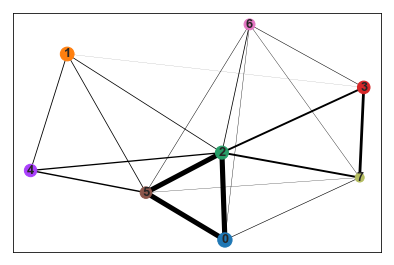

In [81]:
sc.tl.paga(test_filter2, groups='louvain')
sc.pl.paga(test_filter2)